## Pegando os Dados

Vamos usar os como dados a base *[Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)*. Baixe o a pasta e extraia o arquivo `hour.csv`.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
data = pd.read_csv("/home/matheus/Downloads/Bike-Sharing-Dataset/hour.csv")
data.sort_values(["dteday", "hr"], inplace=True)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Vamos usar apenas demanda (`cnt`) passada para tentar prever a demanda na hora seguinte. A seguir, criamos 10 lags dessa variável. Assim, vamos usar as demandas das dez horas passadas para tentar prever a demanda da hora seguinte.

In [3]:
demanda = data[['cnt']]
n_steps = 10

# faz 10 lags da variável cnt
for time_step in range(1, n_steps+1):
    demanda['cnt'+str(time_step)] = demanda[['cnt']].shift(-time_step).values

demanda.dropna(inplace=True) # dropa os lags que resultaram e nulos
demanda.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,cnt,cnt1,cnt2,cnt3,cnt4,cnt5,cnt6,cnt7,cnt8,cnt9,cnt10
0,16,40.0,32.0,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0
1,40,32.0,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0
2,32,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0
3,13,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0,94.0
4,1,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0,94.0,106.0


Separamos as demandas que serão usadas como variáveis e aquela que será prevista

In [4]:
X = demanda.iloc[:, :n_steps].values
y = demanda.iloc[:, -1:].values

print(X.shape, y.shape)

(17369, 10) (17369, 1)


Separamos os dados em treino e teste, mantendo as últimas 500 horas para teste.

In [5]:
n_test = 500

X_train, X_test = X[:-n_test, :], X[-n_test:, :]
y_train, y_test = y[:-n_test, :], y[-n_test:, :]

Embaralhamos os dados de treino para treinar com Gradiente Descendente Estocástico

In [6]:
shuffle_mask = np.arange(0, X_train.shape[0])
np.random.shuffle(shuffle_mask)

X_train = X_train[shuffle_mask]
y_train = y_train[shuffle_mask]

In [7]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


Construímos a nossa rede neural

In [8]:
n_input = X.shape[-1]
num_out = 1

p_dropout = 0.5
lbd = 1e-4

model = Sequential()
model.add(Dropout(.05, input_shape=(n_input,)))
model.add(Dense(100, activation='relu', input_shape=(n_input,), kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(num_out, activation=None))
model.summary()

opt = Adam(lr=1e-3)

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mean_absolute_error'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________


Treinamos a rede por 15000 iterações.

In [9]:
epochs = 3000
model.fit(X_train, y_train,
            batch_size=X_train.shape[0] // 5,
            epochs=epochs,
            verbose=0)

Avaliamos a performance do modelo

In [10]:
from sklearn import metrics

y_hat_train = model.predict(X_train)
metrics.r2_score(y_train, y_hat_train)

0.72982305985440576

In [11]:
y_hat_test = model.predict(X_test)
metrics.r2_score(y_test, y_hat_test)

0.77552577055910255

Plotamos as previsões contra os valores observados

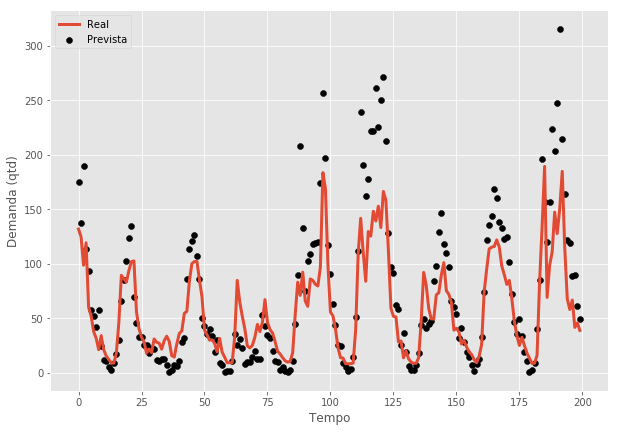

In [12]:
n = 200

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(range(n), y_hat_test[-200:], label="Real", lw=3)
plt.scatter(range(n), y_test[-200:], color="black", label="Prevista")
plt.ylabel("Demanda (qtd)")
plt.xlabel("Tempo")
plt.legend(loc="best")
f.savefig("rnn_demanda1.png")
plt.show()

## Incerteza
Realizamos 1000 *forwad-passes* pela rede neural e obtemos 1000 previsões para cada ponto.

In [13]:
T = 1000
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_test, 1]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1,y_test.shape[0]).T

In [14]:
y_hat_mc.shape

(500, 1000)

Computamos média e variância para cada ponto no set de teste.

In [15]:
l = 10
y_hat_test_mean = np.mean(y_hat_mc, axis=1)
y_hat_test_variance = np.var(y_hat_mc, axis=1)
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_test_variance += tau**-1

Avaliamos a performance do modelo

In [16]:
metrics.r2_score(y_test, y_hat_test_mean)

0.91519016398690467

Novamente, plotamos as previsões contra os valores observados. Além disso, colocamos um sombreado de 4 trons para denotar a variância. Cada tom representa meio desvio padrão da média.

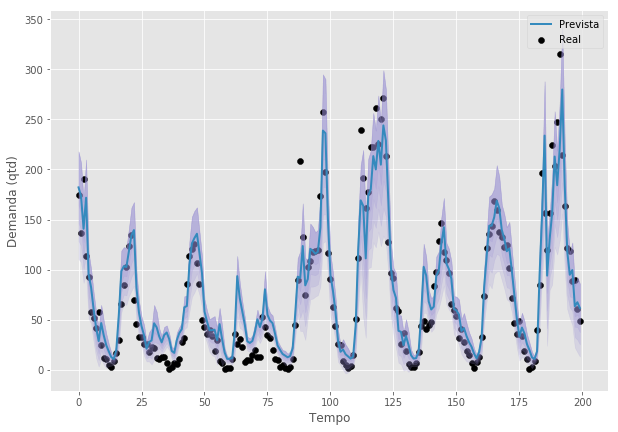

In [17]:
n = 200
t = range(n) 
mu = y_hat_test_mean[-200:]
sigma = np.sqrt(y_hat_test_variance[-200:])

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista", color="C1", lw=2)
plt.scatter(t, y_test[-200:], color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma * (.5*shade), alpha=0.2, color="C2")

plt.ylabel("Demanda (qtd)")
plt.xlabel("Tempo")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

Repetimos o mesmo experimento para o treino.

In [18]:
X_train,y_train = X[:-n_test, :], y[:-n_test, :]

T = 1000
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_train, 1]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1,y_train.shape[0]).T

In [19]:
l = 10
y_hat_train_mean = np.mean(y_hat_mc, axis=1)
y_hat_train_variance = np.var(y_hat_mc, axis=1)
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_train_variance += tau**-1

In [20]:
metrics.r2_score(y_train, y_hat_train_mean)

0.93134696120824234

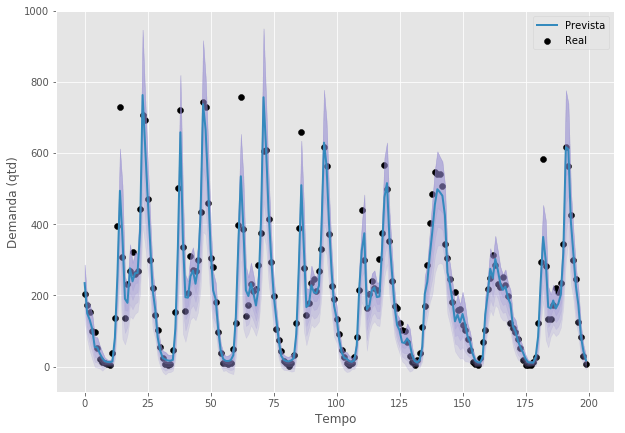

In [21]:
n = 200
t = range(n) 
mu = y_hat_train_mean[-200:]
sigma = np.sqrt(y_hat_train_variance[-200:])

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista", color="C1", lw=2)
plt.scatter(t, y_train[-200:], color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma * (.5*shade), alpha=0.2, color="C2") # 90% IC

plt.ylabel("Demanda (qtd)")
plt.xlabel("Tempo")
plt.legend(loc="best")
f.savefig("rnn_demanda_train.png")
plt.show()